# Machine Learning in Finance - Models Training

This notebook will focus on *how well we can forecast closing stocks using machine learning methods*.

*Authors:* [Mina Attia](https://people.epfl.ch/mina.attia), [Arnaud Felber](https://people.epfl.ch/arnaud.felber), [Rami Atassi](https://people.epfl.ch/rami.atassi) & [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho)

## Import

Import all python scripts and/or libraries needed.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from models.linear_regression import OLS, OLSLasso
from models.pearson_correlation import PearsonCorrelation
from models.random_forest import RandomForest

%load_ext autoreload
%autoreload 2

## Data

We load the data processed with no `NaN` values. Please note that each predictor also are standardize for coherence between them.

In [2]:
# Initiate the data path and label to optimize
file_path = 'data/data_imputed.csv'
label = 'return'
seed = 42

# Load the data
data = pd.read_csv(filepath_or_buffer=file_path)
X = data.drop(columns=['permno', 'date', 'return', 'log_return', 'price', 'log_price'])
y = data[label]

# Standardize data
scaler = StandardScaler() # Note in import step, you can choose other standardization method.
X = pd.DataFrame(scaler.fit_transform(X=X), columns=X.columns)

# Split in train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Just for debugging process, reduce the dataset size to take only first 100 records
X_train, X_test, y_train, y_test = X_train.head(100000), X_test.head(100000), y_train.head(100000), y_test.head(100000)

## Methods

Describe which method we will train and test.

### Person Correlation Matrix

This allows to see which predictors are highly correlated. If two predictors are highly correlated we might don't want to keep both then we delete the least correlated with our label (return).

,pair,correlation
0,"(EBM, BPEBM)",0.999808
1,"(AM, Leverage)",0.986174
2,"(RealizedVol, IdioVol3F)",0.982106
3,"(zerotradeAlt12, zerotrade)",0.973945
4,"(Herf, HerfAsset)",0.945221
5,"(dNoa, NOA)",0.944448
6,"(zerotrade, zerotradeAlt1)",0.942450
7,"(dNoa, InvestPPEInv)",0.923709
8,"(Size, DolVol)",0.922138
9,"(dNoa, AssetGrowth)",0.918073


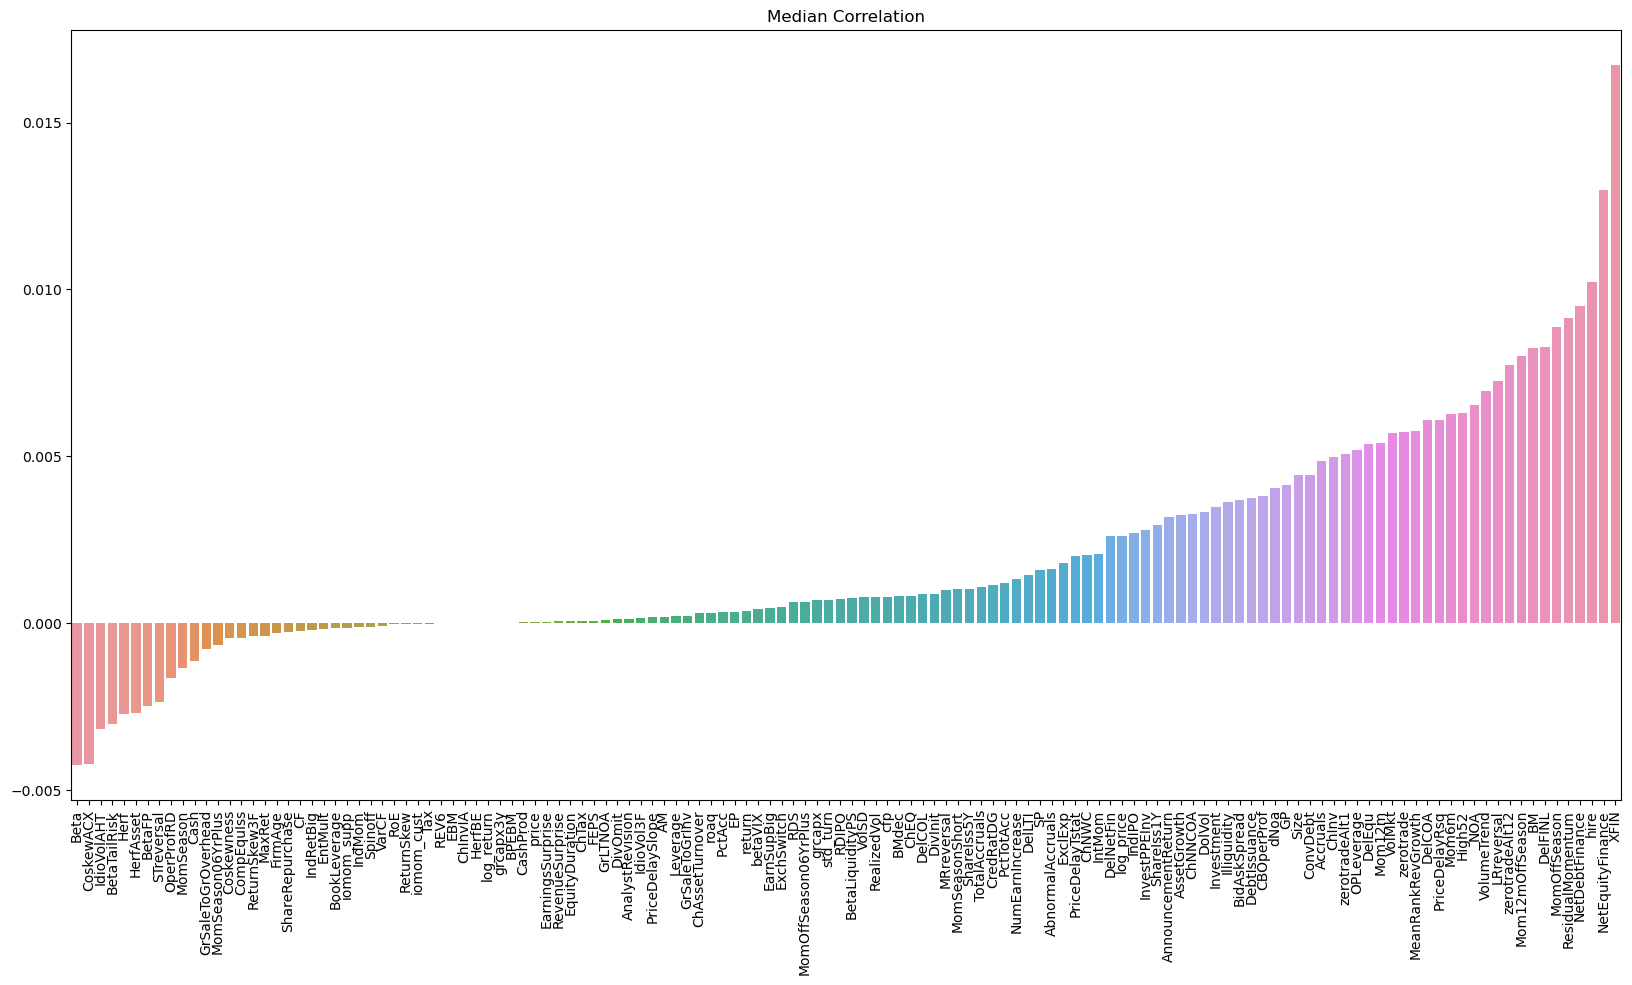

In [3]:
# Compute the correlation between predictors
correlation = PearsonCorrelation(data=data) # Takes a minute

# Display the top 10 most positively correlated
highest_pairs_correlation = correlation.get_sorted_correlation_pairs(ascending=False, top_k_pairs=10)
display(highest_pairs_correlation)

# Finally, plot the median correlation between a predictors and the others
correlation.plot(plot_type= 'median') # plot_type can be 'mean' or 'median' (or 'heatmap' but it is not recommended for large datasets)

It is interesting that Beta is inversely correlated with the other predictors, which accentuates the importance of the other predictors compared to a traditional market prediction.

### OLS

One basic idea is to compute the linear regression of our predictors in function of our label and to see the weights given to each predictor. As seen in class, using regularization can help achieve predictors selection. We then implement :

1) Simple OLS
2) Lasso OLS
3) Elastic Net


#### Simple OLS

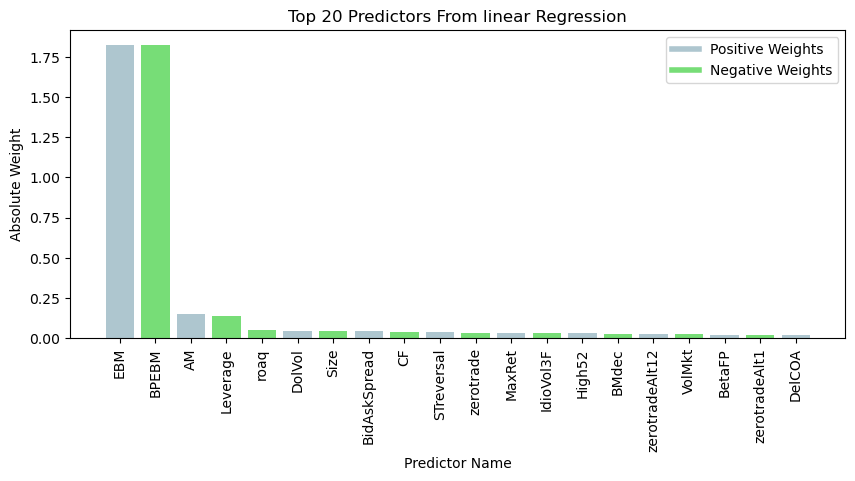

Training R-Square of the Simple OLS: 0.014


In [4]:
# Initiate Simple OLS model
ols_model = OLS(predictors=X_train,
                label=y_train)

# Train the model, show OLS selected weights and training R_square
ols_model.fit()
ols_model.show_weights()
print(f'Training R-Square of the Simple OLS: {ols_model.r_square:.3f}')

#### Lasso OLS

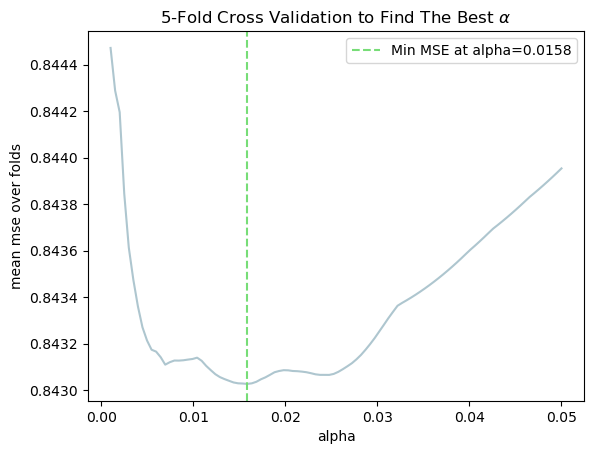

In [5]:
# Initiate Lasso model
ols_lasso_model = OLSLasso(predictors=X_train,
                           label=y_train,
                           alpha=None)  # Note, that alpha set to None will produce a CV step to found the optimal alpha

# Train the model
ols_lasso_model.fit()

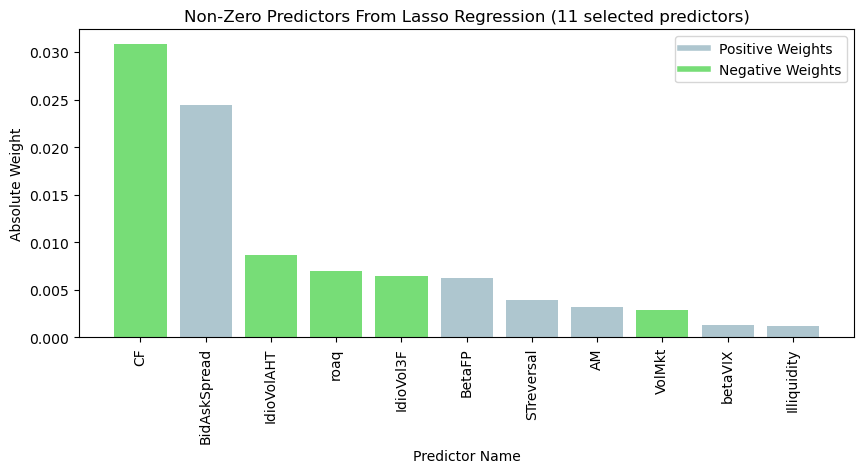

Training R-Square of the Lasso OLS: 0.008


In [6]:
# Once alpha have been properly set, show Lasso selected weights and training R_square
ols_lasso_model.show_weights()
print(f'Training R-Square of the Lasso OLS: {ols_lasso_model.r_square:.3f}')

#### Elastic Net

In [ ]:
import sklearn.linear_model as sk
N_JOBS = 4
VERBOSE = 1

# #elastic net
#
# model = sk.ElasticNet(alpha=0.1, l1_ratio=0.1)
# model.fit(X, y)
# model.score(X, y)
model = sk.LassoCV(cv=3, n_jobs=l, verbose=VERBOSE, n_alphas=10)
model.fit(X, y)
model.score(X, y)

### Random Forest

Using Random Forest can also be a good way to select predictors. We then train a Random Forest into our label using the whole Dataset and we look at the importance of each predictors.

In [44]:
# test_data = data.sample(300000)
rf = RandomForest(data=data, target='return')

In [ ]:
rf.hyperparameter_tuning_with_crossvalidation(nmax_features=['sqrt', 'log2'], n_estimators=[50, 150], max_depth=[3],cv_splits=3, n_jobs=N_JOBS, verbose=VERBOSE)

27 min... Zzzz

In [46]:
rf.set_model(n_jobs=N_JOBS, verbose = VERBOSE, n_estimators=100, max_depth=3, max_features='log2')
rf.fit_predict_and_print_score()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


With the following data:
- Data shape: (1745273, 129)
- Target: return
and the following hyperparameters:
- n_estimators: 100
- max_depth: 3
- max_features: log2
The R2 score is: -0.017611908143600585
The MSE is: 0.22076142212382305


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


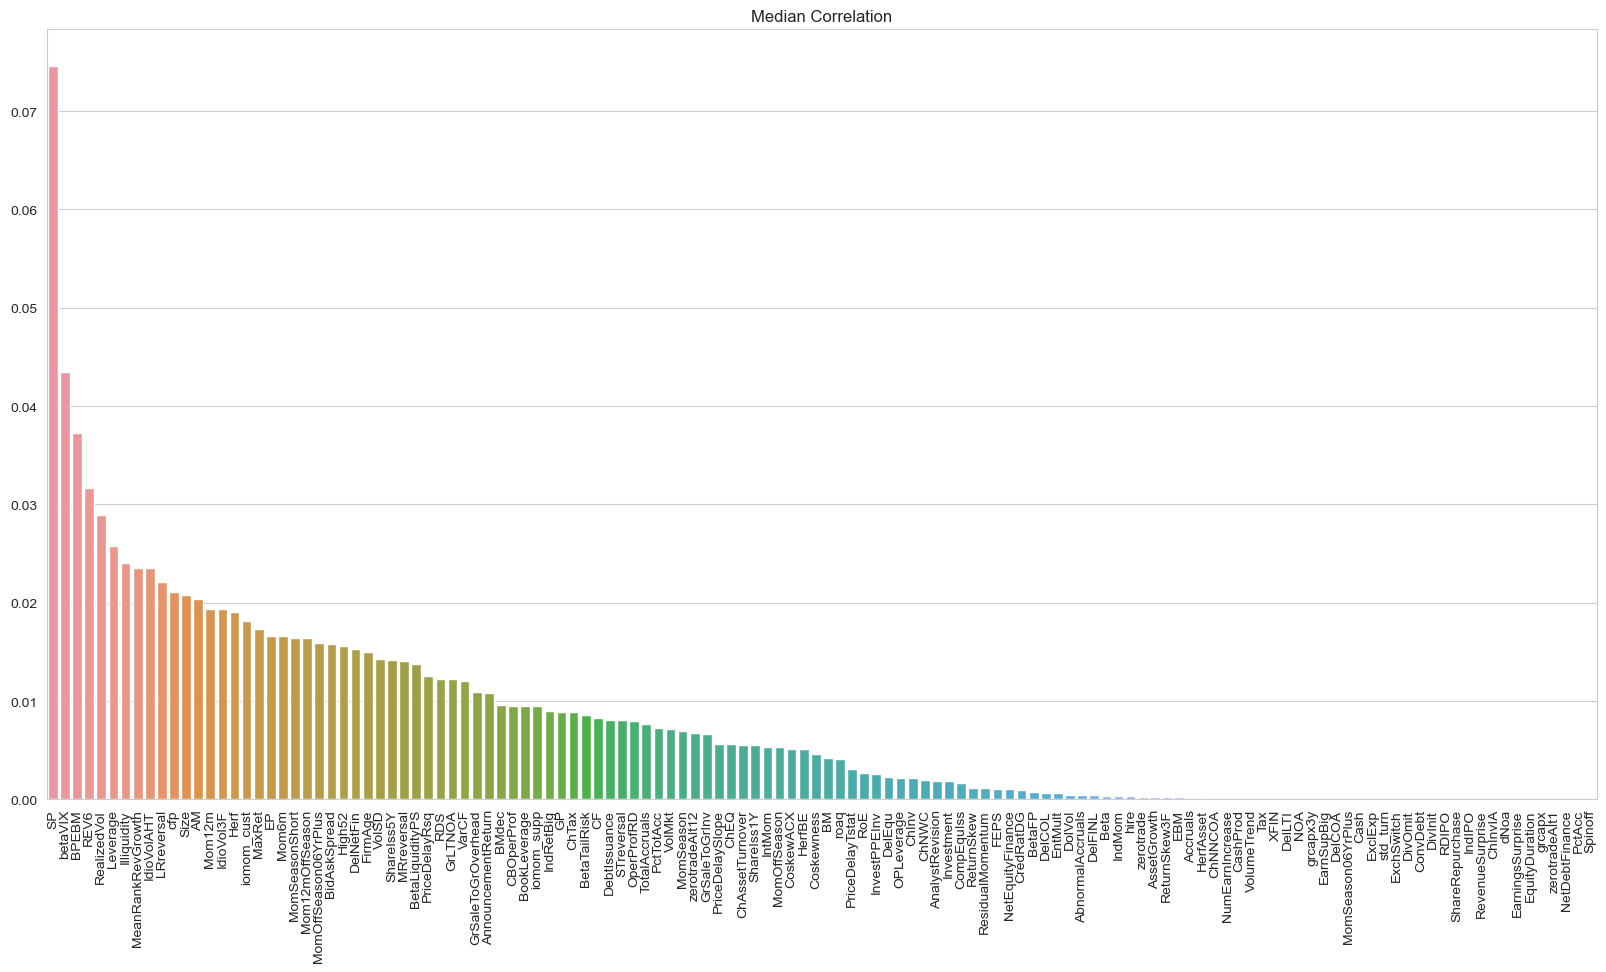

In [50]:
rf.plot_feature_importance()

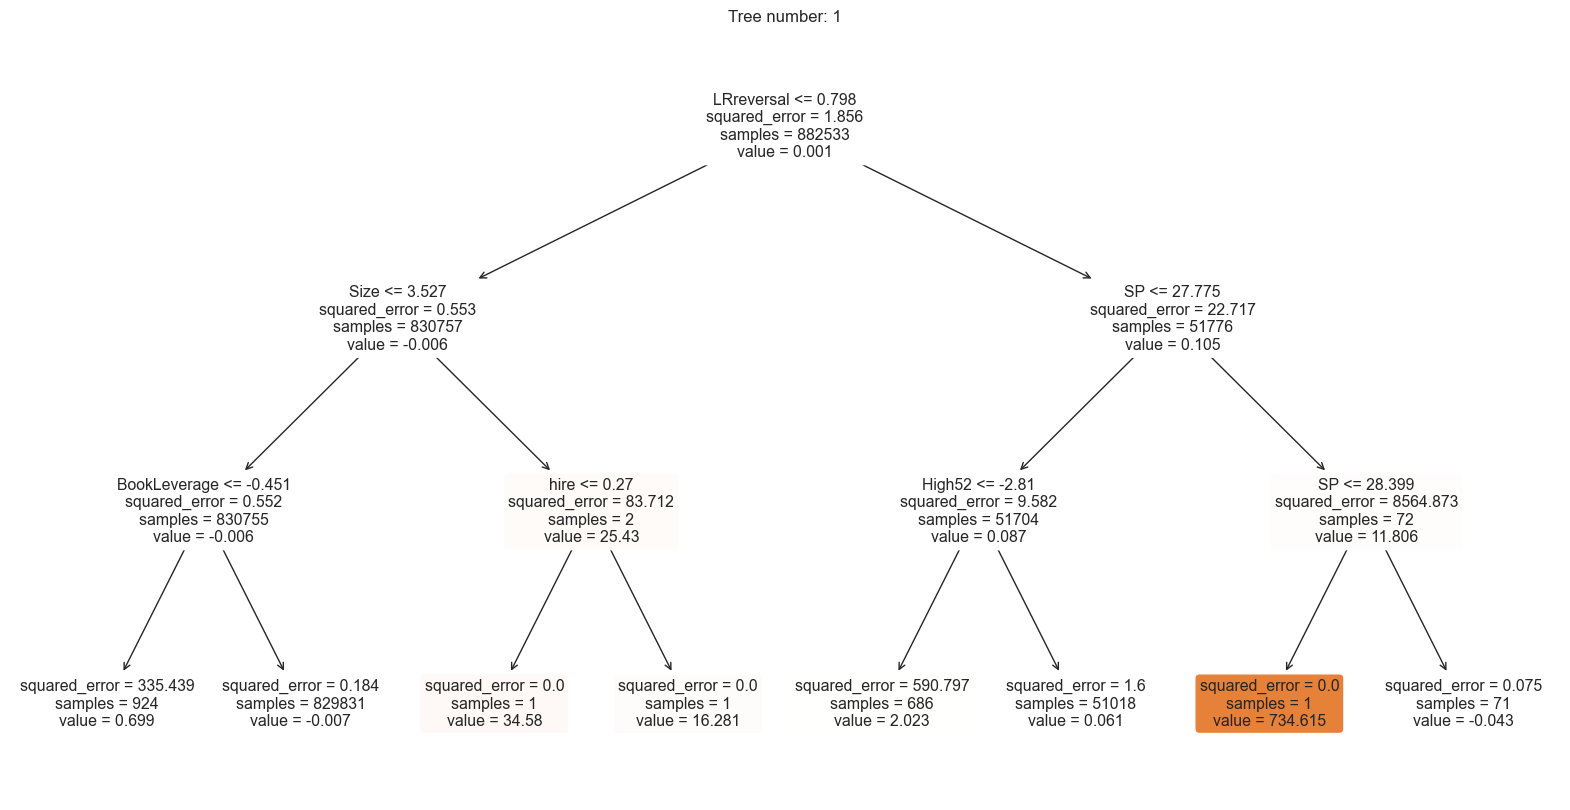

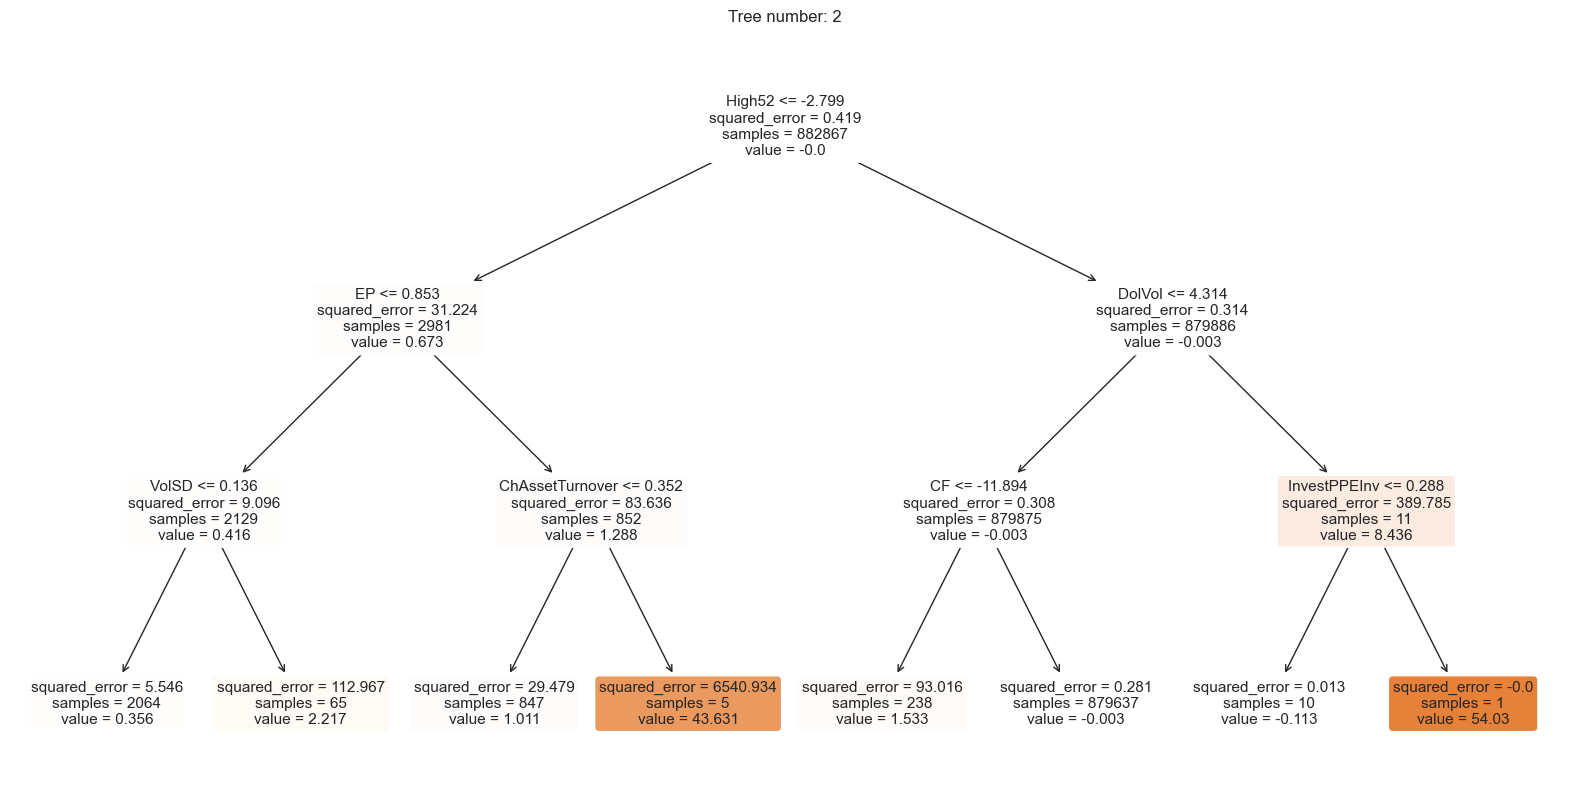

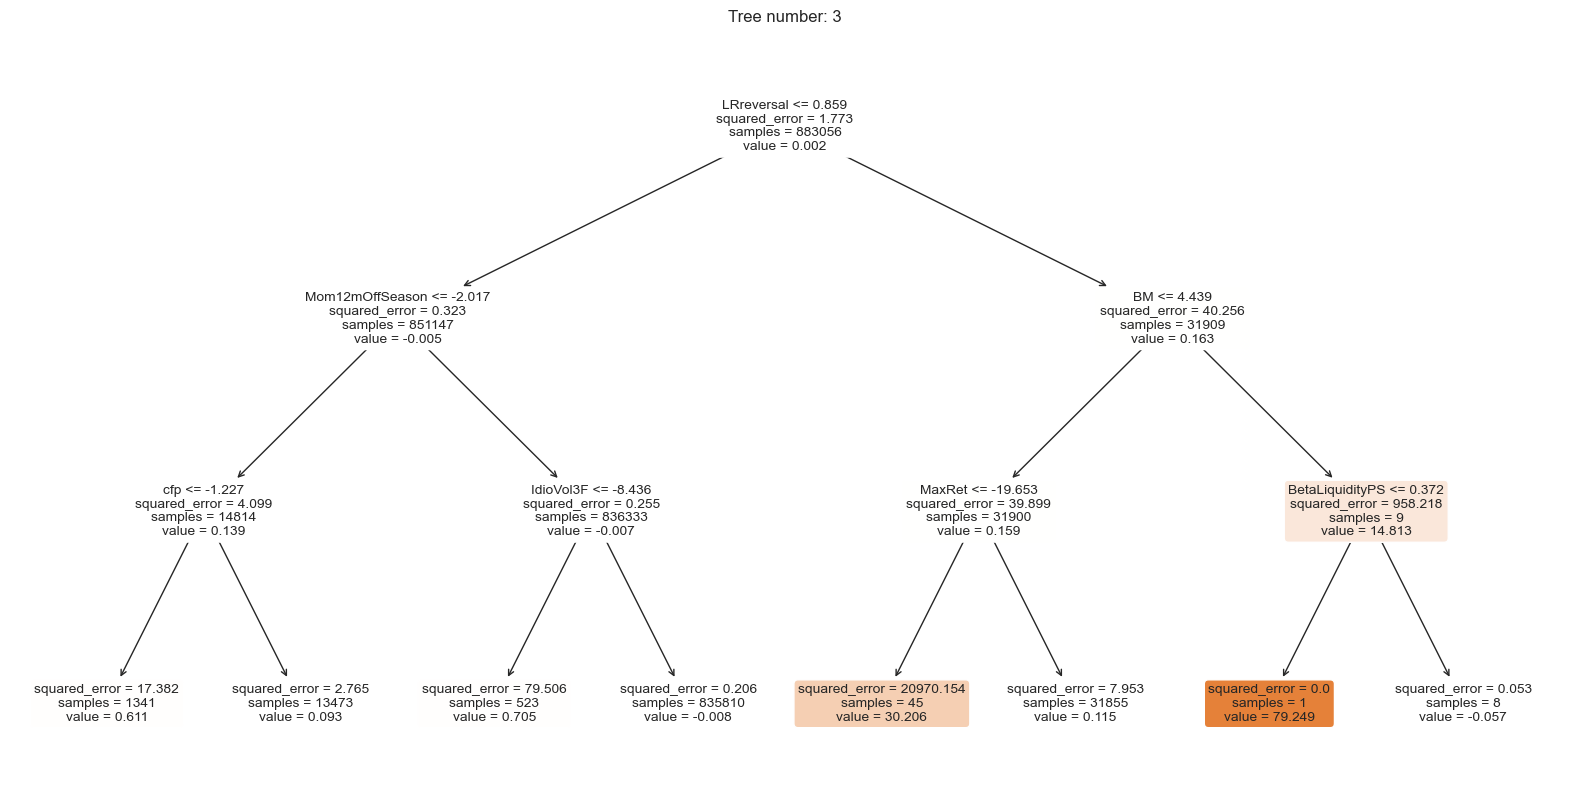

In [51]:
rf.plot_decision_tree()

## Results

We will test our models and compare them to see which one outperform the others.